### tabnet

In [1]:
import os
import numpy as np
import pandas as pd

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [3]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

In [4]:
from compare_hyperparams import load_feats, full_labels, remove_subjs, objective, feature_importance

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [5]:
from compare_bfl_qsidp import proc_qsidp, load_qscode

In [6]:
# bestIC = 500
bestIC = 30
# bestIC = 100

In [10]:
def make_data_paincontrol(bestIC, qs_ls='all', idp_ls='all'):
    bfloutput_dir='/well/tracey/shared/fps-ukb/bigflica_output/output_paincontrol_500/'
    curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
    d = f'Result_IC{bestIC}'
    data_dir = os.path.join(bfloutput_dir, d)
    df_out = pd.read_csv(os.path.join(curr_dir, 'labels_full', 'label_paincontrol.csv'))
    df_featout_ex = remove_subjs(data_dir, df_out, remove_dup=False)
    # load qsidp (section to match bfl, impute, dummify)
    if qs_ls is not None or idp_ls is not None:
        df_qsidp = pd.read_csv(os.path.join(curr_dir,'qsidp','qsidp_patients_pain.csv'))
        df_qs_imputed_dum = proc_qsidp(df_qsidp, df_featout_ex, questionnaire=qs_ls, idp=idp_ls)
        print(f'df_qs_imputed_dum shape={df_qs_imputed_dum.shape}')
        # merge bfl and qsidp
        df_bfl_qsidp = df_featout_ex.merge(df_qs_imputed_dum, left_on='eid', right_on='eid', how='left',indicator=False)
    else:
        df_bfl_qsidp = df_featout_ex
    print(f'df_bfl_qsidp shape={df_bfl_qsidp.shape}')
    return df_bfl_qsidp

In [11]:
def make_data(bestIC, qs_ls='all', idp_ls='all'):
    bfloutput_dir='/well/seymour/users/uhu195/python/pain/output_patients_500'
    curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
    d = f'Result_IC{bestIC}'
    data_dir = os.path.join(bfloutput_dir, d)
    df_out = full_labels('patients_pain', save=False)
    df_featout_ex = remove_subjs(data_dir, df_out) # remove multiple conditions
    # load qsidp (section to match bfl, impute, dummify)
    if qs_ls is not None or idp_ls is not None:
        df_qsidp = pd.read_csv(os.path.join(curr_dir,'qsidp','qsidp_patients_pain.csv'))
        df_qs_imputed_dum = proc_qsidp(df_qsidp, df_featout_ex, questionnaire=qs_ls, idp=idp_ls)
        print(f'df_qs_imputed_dum shape={df_qs_imputed_dum.shape}')
        # merge bfl and qsidp
        df_bfl_qsidp = df_featout_ex.merge(df_qs_imputed_dum, left_on='eid', right_on='eid', how='left',indicator=False)
    else:
        df_bfl_qsidp = df_featout_ex
    print(f'df_bfl_qsidp shape={df_bfl_qsidp.shape}')
    return df_bfl_qsidp

In [12]:
def make_binary(bestIC, disease_ls=['migraine', 'back pain']):
    bfloutput_dir='/well/seymour/users/uhu195/python/pain/output_patients_500'
    curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
    d = f'Result_IC{bestIC}'
    data_dir = os.path.join(bfloutput_dir, d)
    df_out = full_labels('patients_pain', save=False)
    df_featout_ex = remove_subjs(data_dir, df_out) # remove multiple conditions
    # load qsidp (section to match bfl, impute, dummify)
    qs_ls = 'all'
    idp_ls = 'all'
    # idp_ls = None
    if qs_ls is not None or idp_ls is not None:
        df_qsidp = pd.read_csv(os.path.join(curr_dir,'qsidp','qsidp_patients_pain.csv'))
        df_qs_imputed_dum = proc_qsidp(df_qsidp, df_featout_ex, questionnaire=qs_ls, idp=idp_ls)
        print(f'df_qs_imputed_dum shape={df_qs_imputed_dum.shape}')
        # merge bfl and qsidp
        df_bfl_qsidp = df_featout_ex.merge(df_qs_imputed_dum, left_on='eid', right_on='eid', how='left',indicator=False)
    else:
        df_bfl_qsidp = df_featout_ex
    print(f'df_bfl_qsidp shape={df_bfl_qsidp.shape}')
    
    # extract and concat
    df_binary = df_bfl_qsidp[(df_bfl_qsidp[disease_ls[0]]==1) | (df_bfl_qsidp[disease_ls[1]]==1)]
    print(df_binary.shape)
    return df_binary

In [13]:
def match_question(q_codes, questionnaire='all', idp='all'):
    """backward search questions to match question code"""
    df_qs = load_qscode(questionnaire=questionnaire, idp=idp)
    question_ls = []
    for c in q_codes:
        if isinstance(c, str):
            code = int(c.split('-')[0])
            question = df_qs[df_qs['code']==code]['Field title'].values
            question_ls.append(question)
    return question_ls

### testing paincontrol

In [22]:
dff = make_data_paincontrol(bestIC=30, qs_ls=None, idp_ls=None)

df_bfl_qsidp shape=(4558, 33)


In [23]:
X_train, y_train, X_valid, y_valid = load_feats(dff, bestIC, test_size=0.25,
                                                dummies=False,
                                                train=True, balance=True, scaler=True)

(4558, 30)


In [25]:
y_train.value_counts()

1    1709
0    1708
Name: label, dtype: int64

In [26]:
y_valid.value_counts()

0    570
1    569
Name: label, dtype: int64

In [27]:
import optuna

In [28]:
def objective(trial, X, y):
    """tuning using optuna"""
    from sklearn.model_selection import train_test_split
    import sklearn.ensemble
    import sklearn.model_selection
    
#     X, y = load_feats(dataset='patient', train=False)
#     X, y = load_feats(data_input, IC_num, train=False)

#     classifier_name = trial.suggest_categorical("classifier", ["RandomForest"])
    rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    list_trees = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
    rf_n_estimators = trial.suggest_categorical('n_estimators', list_trees)
    rf_max_features = trial.suggest_uniform('max_features', 0.15, 1.0)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 14)
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 14)
    rf_max_samples = trial.suggest_uniform('max_samples', 0.6, 0.99)
            
    classifier_obj = sklearn.ensemble.RandomForestClassifier(
        max_depth=rf_max_depth, n_estimators=rf_n_estimators, max_features=rf_max_features, 
        min_samples_split=rf_min_samples_split, min_samples_leaf=rf_min_samples_leaf, max_samples=rf_max_samples,
        bootstrap=True, verbose=0
    )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, 
                                                    n_jobs=-1, cv=3, scoring='balanced_accuracy')
    accuracy = score.mean()
#     accuracy = balanced_accuracy_score(y, clf.predict(X))
    return accuracy

In [47]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)
bp = study.best_trial.params
print(bp)

[I 2021-10-27 11:07:52,556] A new study created in memory with name: no-name-24ab5309-90ed-418b-aafe-55298bd14377
[I 2021-10-27 11:07:55,298] Trial 0 finished with value: 0.5326426787531219 and parameters: {'max_depth': 29, 'n_estimators': 175, 'max_features': 0.442387789181208, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_samples': 0.7153824665148808}. Best is trial 0 with value: 0.5326426787531219.
[I 2021-10-27 11:07:57,690] Trial 1 finished with value: 0.5355825856380846 and parameters: {'max_depth': 10, 'n_estimators': 175, 'max_features': 0.3667207516569104, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.8939406633607585}. Best is trial 1 with value: 0.5355825856380846.
[I 2021-10-27 11:08:02,726] Trial 2 finished with value: 0.5405487209529388 and parameters: {'max_depth': 7, 'n_estimators': 225, 'max_features': 0.8626406283748276, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_samples': 0.9403569355257924}. Best is trial 2 with value: 0.54054872095

{'max_depth': 4, 'n_estimators': 250, 'max_features': 0.4183698627815782, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_samples': 0.7034247360682754}


In [48]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [49]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=0.4183698627815782,
                       max_samples=0.7034247360682754, min_samples_leaf=8,
                       min_samples_split=4, n_estimators=250)

In [50]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

3417
0.6906720927778683
0.6906643254316652


In [51]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

1139
0.5539789720346561
0.5539947322212467


In [53]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

0.578043967563901

In [54]:
output_ls = ['label', 'eid', 'bmrc']
tmp = dff.drop(columns=output_ls)
feature_names = tmp.columns

In [55]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [56]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

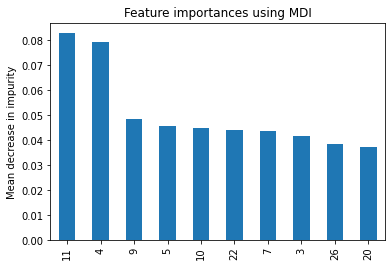

In [58]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

#### tabnet

In [69]:
import torch
clf = TabNetClassifier()

clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    eval_name=['train'],
#     eval_metric=['auc'],
    eval_metric=['auc','balanced_accuracy'],
)

Device used : cpu
epoch 0  | loss: 0.81137 | train_auc: 0.50949 | train_balanced_accuracy: 0.51132 |  0:00:00s
epoch 1  | loss: 0.71365 | train_auc: 0.52594 | train_balanced_accuracy: 0.52068 |  0:00:00s
epoch 2  | loss: 0.69886 | train_auc: 0.53183 | train_balanced_accuracy: 0.5271  |  0:00:00s
epoch 3  | loss: 0.69574 | train_auc: 0.54624 | train_balanced_accuracy: 0.53735 |  0:00:01s
epoch 4  | loss: 0.69316 | train_auc: 0.54471 | train_balanced_accuracy: 0.5347  |  0:00:01s
epoch 5  | loss: 0.69392 | train_auc: 0.55123 | train_balanced_accuracy: 0.53119 |  0:00:01s
epoch 6  | loss: 0.68643 | train_auc: 0.55579 | train_balanced_accuracy: 0.5397  |  0:00:01s
epoch 7  | loss: 0.68733 | train_auc: 0.55815 | train_balanced_accuracy: 0.54821 |  0:00:02s
epoch 8  | loss: 0.6906  | train_auc: 0.55593 | train_balanced_accuracy: 0.53854 |  0:00:02s
epoch 9  | loss: 0.68832 | train_auc: 0.55847 | train_balanced_accuracy: 0.53736 |  0:00:02s
epoch 10 | loss: 0.69046 | train_auc: 0.56008 | trai

In [70]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

3417
0.5902730481827163
0.5902838747439274


In [71]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

1139
0.5329556316097801
0.5329236172080772


In [72]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

0.5360928683748034

In [73]:
output_ls = ['label', 'eid', 'bmrc']
tmp = dff.drop(columns=output_ls)
feature_names = tmp.columns

In [74]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [75]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

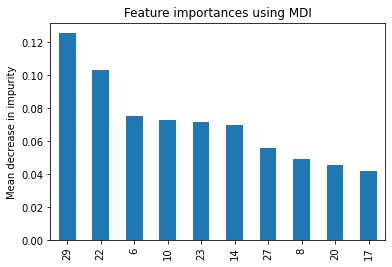

In [76]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

### testing binary

In [10]:
disease = ['migraine', 'back pain']
df_all = make_binary(bestIC, disease)

/well/seymour/users/uhu195/python/extract_npy//labels/label_patients_pain.csv
(2724, 1)
(2724, 6)


/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  


df_qs_imputed_dum shape=(2280, 1165)
df_bfl_qsidp shape=(2280, 1670)
(756, 1670)


In [11]:
X_train, y_train, X_valid, y_valid = load_feats(df_all, bestIC, test_size=0.2,
                                                dummies=False,
                                                train=True, balance=True, scaler=True)

(756, 1664)


In [12]:
y_train.value_counts()

back pain    300
migraine     300
dtype: int64

In [13]:
y_valid.value_counts()

migraine     75
back pain    75
dtype: int64

In [14]:
import torch
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-1),)
# clf = TabNetClassifier()
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)], #, (X_valid, y_valid)
    eval_name=['train'],
    eval_metric=['auc','accuracy','balanced_accuracy'],
)

Device used : cpu
epoch 0  | loss: 1.02682 | train_auc: 0.51271 | train_accuracy: 0.51667 | train_balanced_accuracy: 0.51667 |  0:00:01s
epoch 1  | loss: 0.8165  | train_auc: 0.4452  | train_accuracy: 0.48667 | train_balanced_accuracy: 0.48667 |  0:00:01s
epoch 2  | loss: 0.84111 | train_auc: 0.53061 | train_accuracy: 0.48333 | train_balanced_accuracy: 0.48333 |  0:00:02s
epoch 3  | loss: 0.71768 | train_auc: 0.50003 | train_accuracy: 0.49833 | train_balanced_accuracy: 0.49833 |  0:00:03s
epoch 4  | loss: 0.71659 | train_auc: 0.52306 | train_accuracy: 0.505   | train_balanced_accuracy: 0.505   |  0:00:03s
epoch 5  | loss: 0.69254 | train_auc: 0.52082 | train_accuracy: 0.52833 | train_balanced_accuracy: 0.52833 |  0:00:04s
epoch 6  | loss: 0.68351 | train_auc: 0.5158  | train_accuracy: 0.52    | train_balanced_accuracy: 0.52    |  0:00:05s
epoch 7  | loss: 0.68352 | train_auc: 0.5361  | train_accuracy: 0.53167 | train_balanced_accuracy: 0.53167 |  0:00:05s
epoch 8  | loss: 0.67887 | tra

In [15]:
preds = clf.predict(X_train)
print(len(preds))
print(sum(y_train==preds)/len(y_train))

600
0.63


In [16]:
preds = clf.predict(X_valid)
print(len(preds))
print(sum(y_valid==preds)/len(y_valid))

150
0.5333333333333333


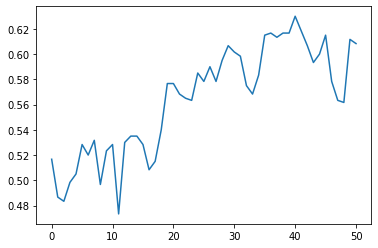

In [17]:
# plot accuracy
plt.plot(clf.history['train_balanced_accuracy'])
# plt.plot(clf.history['valid_balanced_accuracy'])

In [18]:
output_ls = ['irritable bowel syndrome', 'migraine', 'back pain',
       'osteoarthritis', 'eid', 'bmrc']
tmp = df_all.drop(columns=output_ls)
feature_names = tmp.columns

In [19]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [20]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

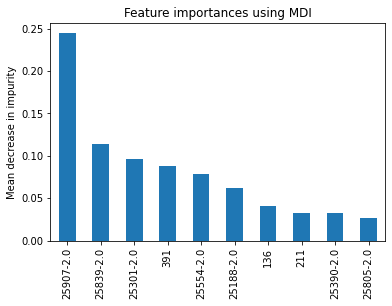

In [21]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [22]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Volume of grey matter in VIIb Cerebellum (vermis)'], dtype=object),
 array(['Volume of grey matter in Cingulate Gyrus anterior division (right)'],
       dtype=object),
 array(['Mean L3 in fornix on FA skeleton'], dtype=object),
 array(['Weighted-mean MO in tract inferior fronto-occipital fasciculus (left)'],
       dtype=object),
 array(['Mean MO in cingulum hippocampus on FA skeleton (right)'],
       dtype=object),
 array(['Mean ICVF in tapetum on FA skeleton (right)'], dtype=object),
 array(['Volume of grey matter in Middle Temporal Gyrus, posterior division (right)'],
       dtype=object)]

#### random forest benchmark

In [23]:
import optuna

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)
bp = study.best_trial.params
print(bp)

[I 2021-10-26 13:11:46,521] A new study created in memory with name: no-name-a80994b2-9b48-4ded-92b1-acd01cea84fd
[I 2021-10-26 13:12:12,950] Trial 0 finished with value: 0.6716666666666667 and parameters: {'max_depth': 26, 'n_estimators': 250, 'max_features': 0.7803421866047426, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_samples': 0.9027679892361957}. Best is trial 0 with value: 0.6716666666666667.
[I 2021-10-26 13:12:16,595] Trial 1 finished with value: 0.6549999999999999 and parameters: {'max_depth': 2, 'n_estimators': 200, 'max_features': 0.2918795846760002, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_samples': 0.8473948872943405}. Best is trial 0 with value: 0.6716666666666667.
[I 2021-10-26 13:12:20,664] Trial 2 finished with value: 0.6566666666666667 and parameters: {'max_depth': 11, 'n_estimators': 75, 'max_features': 0.7660024164081959, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_samples': 0.6072588357098628}. Best is trial 0 with value: 0.67166666666

{'max_depth': 26, 'n_estimators': 250, 'max_features': 0.7803421866047426, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_samples': 0.9027679892361957}


In [25]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [26]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=26, max_features=0.7803421866047426,
                       max_samples=0.9027679892361957, min_samples_leaf=8,
                       min_samples_split=4, n_estimators=250)

In [27]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

600
0.9883333333333333
0.9883333333333333


In [28]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

150
0.6533333333333333
0.6533333333333333


In [29]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [30]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

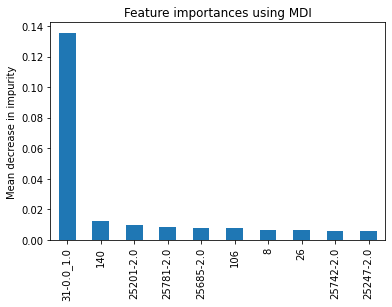

In [31]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [32]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Sex'], dtype=object),
 array(['Mean L1 in pontine crossing tract on FA skeleton'], dtype=object),
 array(['Total volume of white matter hyperintensities (from T1 and T2_FLAIR images)'],
       dtype=object),
 array(['Weighted-mean OD in tract corticospinal tract (left)'],
       dtype=object),
 array(['Mean tfMRI head motion averaged across space and time points'],
       dtype=object),
 array(['Mean L1 in tapetum on FA skeleton (left)'], dtype=object)]

In [153]:
df_all.groupby('back pain')['31-0.0_1.0'].value_counts()

back pain  31-0.0_1.0
0          0             300
           1              81
1          1             206
           0             169
Name: 31-0.0_1.0, dtype: int64

In [157]:
dff = make_data(bestIC)

/well/seymour/users/uhu195/python/extract_npy//labels/label_patients_pain.csv
(2724, 1)
(2724, 6)


/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


df_qs_imputed_dum shape=(2280, 1165)
df_bfl_qsidp shape=(2280, 1670)


In [162]:
dff.groupby(['back pain', 'migraine', 'osteoarthritis', 'irritable bowel syndrome'])['31-0.0_1.0'].value_counts()

back pain  migraine  osteoarthritis  irritable bowel syndrome  31-0.0_1.0
0          0         0               0                         0             186
                                                               1             142
                                     1                         0             229
                                                               1              82
                     1               0                         0             571
                                                               1             314
           1         0               0                         0             300
                                                               1              81
1          0         0               0                         1             206
                                                               0             169
Name: 31-0.0_1.0, dtype: int64

In [ ]:
82+314+81+169

#### trying another combination of disease

In [33]:
disease = ['osteoarthritis', 'back pain']
df_all = make_binary(bestIC, disease)

/well/seymour/users/uhu195/python/extract_npy//labels/label_patients_pain.csv
(2724, 1)
(2724, 6)


/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  


df_qs_imputed_dum shape=(2280, 1165)
df_bfl_qsidp shape=(2280, 1670)
(1260, 1670)


In [34]:
X_train, y_train, X_valid, y_valid = load_feats(df_all, bestIC, test_size=0.2,
                                                dummies=False,
                                                train=True, balance=True, scaler=True)

(1260, 1664)


In [35]:
y_train.value_counts()

back pain         300
osteoarthritis    300
dtype: int64

In [36]:
y_valid.value_counts()

osteoarthritis    75
back pain         75
dtype: int64

In [37]:
import torch
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5e-1),)

clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    eval_name=['train'],
#     eval_metric=['auc'],
    eval_metric=['auc','balanced_accuracy'],
)

Device used : cpu
epoch 0  | loss: 1.04335 | train_auc: 0.48966 | train_balanced_accuracy: 0.5     |  0:00:00s
epoch 1  | loss: 0.93918 | train_auc: 0.51429 | train_balanced_accuracy: 0.5     |  0:00:01s
epoch 2  | loss: 0.92546 | train_auc: 0.47724 | train_balanced_accuracy: 0.5     |  0:00:02s
epoch 3  | loss: 0.73007 | train_auc: 0.52424 | train_balanced_accuracy: 0.50333 |  0:00:02s
epoch 4  | loss: 0.72016 | train_auc: 0.42926 | train_balanced_accuracy: 0.43167 |  0:00:03s
epoch 5  | loss: 0.70038 | train_auc: 0.47451 | train_balanced_accuracy: 0.46833 |  0:00:04s
epoch 6  | loss: 0.70914 | train_auc: 0.52708 | train_balanced_accuracy: 0.50333 |  0:00:04s
epoch 7  | loss: 0.70065 | train_auc: 0.46485 | train_balanced_accuracy: 0.50333 |  0:00:05s
epoch 8  | loss: 0.69156 | train_auc: 0.46031 | train_balanced_accuracy: 0.50333 |  0:00:06s
epoch 9  | loss: 0.69004 | train_auc: 0.47748 | train_balanced_accuracy: 0.505   |  0:00:06s
epoch 10 | loss: 0.69417 | train_auc: 0.54293 | trai

In [38]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

600
0.525
0.525


In [39]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

150
0.48666666666666664
0.4866666666666667


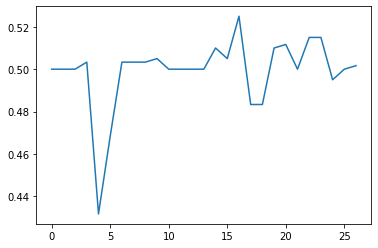

In [40]:
# plot accuracy
plt.plot(clf.history['train_balanced_accuracy'])
# plt.plot(clf.history['valid_balanced_accuracy'])

In [41]:
np.argmax(clf.feature_importances_)

172

In [42]:
output_ls = ['irritable bowel syndrome', 'migraine', 'back pain',
       'osteoarthritis', 'eid', 'bmrc']
tmp = df_all.drop(columns=output_ls)
feature_names = tmp.columns

In [43]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [44]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

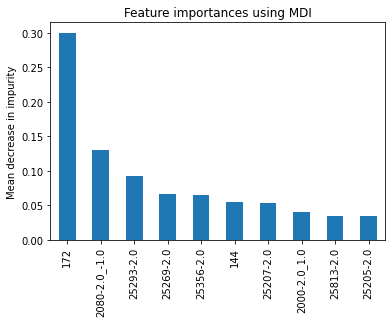

In [45]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [46]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Frequency of tiredness / lethargy in last 2 weeks'], dtype=object),
 array(['Mean L2 in uncinate fasciculus on FA skeleton (left)'],
       dtype=object),
 array(['Mean L2 in retrolenticular part of internal capsule on FA skeleton (left)'],
       dtype=object),
 array(['Mean ICVF in superior cerebellar peduncle on FA skeleton (right)'],
       dtype=object),
 array(['Mean L1 in corticospinal tract on FA skeleton (left)'],
       dtype=object),
 array(['Worry too long after embarrassment'], dtype=object),
 array(['Volume of grey matter in Inferior Temporal Gyrus, temporooccipital part (right)'],
       dtype=object),
 array(['Mean L1 in fornix on FA skeleton'], dtype=object)]

#### random forest benchmark

In [47]:
import optuna

In [48]:
def objective(trial, X, y):
    """tuning using optuna"""
    from sklearn.model_selection import train_test_split
    import sklearn.ensemble
    import sklearn.model_selection
    
#     X, y = load_feats(dataset='patient', train=False)
#     X, y = load_feats(data_input, IC_num, train=False)

#     classifier_name = trial.suggest_categorical("classifier", ["RandomForest"])
    rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    list_trees = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
    rf_n_estimators = trial.suggest_categorical('n_estimators', list_trees)
    rf_max_features = trial.suggest_uniform('max_features', 0.15, 1.0)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 14)
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 14)
    rf_max_samples = trial.suggest_uniform('max_samples', 0.6, 0.99)
            
    classifier_obj = sklearn.ensemble.RandomForestClassifier(
        max_depth=rf_max_depth, n_estimators=rf_n_estimators, max_features=rf_max_features, 
        min_samples_split=rf_min_samples_split, min_samples_leaf=rf_min_samples_leaf, max_samples=rf_max_samples,
        bootstrap=True, verbose=0
    )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, 
                                                    n_jobs=-1, cv=3, scoring='balanced_accuracy')
    accuracy = score.mean()
#     accuracy = balanced_accuracy_score(y, clf.predict(X))
    return accuracy

In [49]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)
bp = study.best_trial.params
print(bp)

[I 2021-10-26 13:16:11,786] A new study created in memory with name: no-name-bcea5cd3-708f-4489-b9af-41519b2c9eef
[I 2021-10-26 13:16:12,542] Trial 0 finished with value: 0.5983333333333333 and parameters: {'max_depth': 21, 'n_estimators': 25, 'max_features': 0.2565806157982235, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_samples': 0.8756813673509457}. Best is trial 0 with value: 0.5983333333333333.
[I 2021-10-26 13:16:14,021] Trial 1 finished with value: 0.6133333333333334 and parameters: {'max_depth': 3, 'n_estimators': 100, 'max_features': 0.20276010129538194, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_samples': 0.9070460931350194}. Best is trial 1 with value: 0.6133333333333334.
[I 2021-10-26 13:16:19,935] Trial 2 finished with value: 0.61 and parameters: {'max_depth': 14, 'n_estimators': 125, 'max_features': 0.5851775281434606, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_samples': 0.9102479739071414}. Best is trial 1 with value: 0.6133333333333334.
[I 202

{'max_depth': 3, 'n_estimators': 100, 'max_features': 0.20276010129538194, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_samples': 0.9070460931350194}


In [50]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [51]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=0.20276010129538194,
                       max_samples=0.9070460931350194, min_samples_leaf=9,
                       min_samples_split=9)

In [52]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

600
0.81
0.81


In [53]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

150
0.5733333333333334
0.5733333333333334


In [54]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [55]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

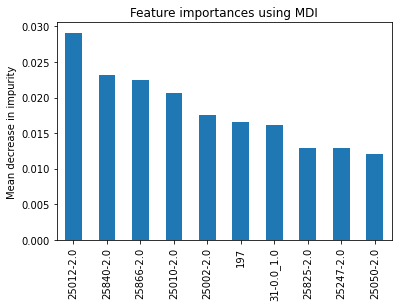

In [56]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [57]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Volume of thalamus (right)'], dtype=object),
 array(['Volume of grey matter in Cingulate Gyrus posterior division (left)'],
       dtype=object),
 array(['Volume of grey matter in Parietal Operculum Cortex (left)'],
       dtype=object),
 array(['Volume of brain grey+white matter'], dtype=object),
 array(['Volume of peripheral cortical grey matter'], dtype=object),
 array(['Sex'], dtype=object),
 array(['Volume of grey matter in Lateral Occipital Cortex, superior division (right)'],
       dtype=object),
 array(['Mean L1 in tapetum on FA skeleton (left)'], dtype=object),
 array(['Median z-statistic (in group-defined mask) for faces-shapes contrast'],
       dtype=object)]

#### random forest benchmark

In [85]:
dff = make_data(bestIC)

/well/seymour/users/uhu195/python/extract_npy//labels/label_patients_pain.csv
(2724, 1)
(2724, 6)


/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


df_qs_imputed_dum shape=(2280, 1165)
df_bfl_qsidp shape=(2280, 1670)


In [86]:
dff_rm = dff.drop(['31-0.0_1.0', '25742-2.0', '21003-2.0'], axis=1)

In [87]:
X_train, y_train, X_valid, y_valid = load_feats(dff_rm, bestIC, test_size=0.25,
                                                dummies=False,
                                                train=True, balance=True, scaler=True)

(2280, 1661)


In [88]:
y_train.value_counts()

irritable bowel syndrome    282
migraine                    281
osteoarthritis              281
back pain                   281
dtype: int64

In [89]:
y_valid.value_counts()

back pain                   94
osteoarthritis              94
migraine                    94
irritable bowel syndrome    93
dtype: int64

In [42]:
import optuna

In [90]:
def objective(trial, X, y):
    """tuning using optuna"""
    from sklearn.model_selection import train_test_split
    import sklearn.ensemble
    import sklearn.model_selection
    
#     X, y = load_feats(dataset='patient', train=False)
#     X, y = load_feats(data_input, IC_num, train=False)

#     classifier_name = trial.suggest_categorical("classifier", ["RandomForest"])
    rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    list_trees = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
    rf_n_estimators = trial.suggest_categorical('n_estimators', list_trees)
    rf_max_features = trial.suggest_uniform('max_features', 0.15, 1.0)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 14)
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 14)
    rf_max_samples = trial.suggest_uniform('max_samples', 0.6, 0.99)
            
    classifier_obj = sklearn.ensemble.RandomForestClassifier(
        max_depth=rf_max_depth, n_estimators=rf_n_estimators, max_features=rf_max_features, 
        min_samples_split=rf_min_samples_split, min_samples_leaf=rf_min_samples_leaf, max_samples=rf_max_samples,
        bootstrap=True, verbose=0
    )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, 
                                                    n_jobs=-1, cv=3, scoring='balanced_accuracy')
    accuracy = score.mean()
#     accuracy = balanced_accuracy_score(y, clf.predict(X))
    return accuracy

In [92]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)
bp = study.best_trial.params
print(bp)

[I 2021-10-26 14:41:22,941] A new study created in memory with name: no-name-d11b0873-4789-47ed-8a69-c0b18ce23f2b
[I 2021-10-26 14:41:28,822] Trial 0 finished with value: 0.3129051323114467 and parameters: {'max_depth': 10, 'n_estimators': 50, 'max_features': 0.26499205600439324, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_samples': 0.734251006789272}. Best is trial 0 with value: 0.3129051323114467.
[I 2021-10-26 14:41:54,333] Trial 1 finished with value: 0.3113322656905361 and parameters: {'max_depth': 3, 'n_estimators': 250, 'max_features': 0.5661093601501203, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_samples': 0.7769000186798598}. Best is trial 0 with value: 0.3129051323114467.
[I 2021-10-26 14:41:57,878] Trial 2 finished with value: 0.3121139327385038 and parameters: {'max_depth': 2, 'n_estimators': 50, 'max_features': 0.8150861096597161, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_samples': 0.6803216793801059}. Best is trial 0 with value: 0.31290513231144

{'max_depth': 18, 'n_estimators': 250, 'max_features': 0.7404883598631531, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_samples': 0.862665090004177}


In [93]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [94]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, max_features=0.7404883598631531,
                       max_samples=0.862665090004177, min_samples_leaf=13,
                       min_samples_split=4, n_estimators=250)

In [95]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

1125
0.989330153201585
0.9893333333333333


In [96]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

375
0.3435712651567147
0.344


In [97]:
from sklearn.metrics import roc_auc_score

In [98]:
roc_auc_score(y_valid, clf.predict_proba(X_valid), multi_class='ovr')

0.6124850159562933

In [53]:
output_ls = ['irritable bowel syndrome', 'migraine', 'back pain',
       'osteoarthritis', 'eid', 'bmrc']
tmp = dff_rm.drop(columns=output_ls)
feature_names = tmp.columns

In [54]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [55]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

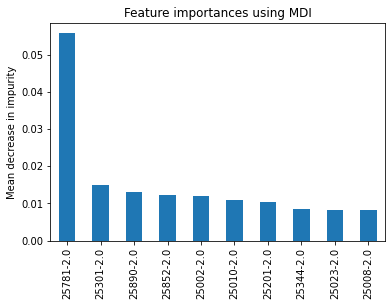

In [56]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [57]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Total volume of white matter hyperintensities (from T1 and T2_FLAIR images)'],
       dtype=object),
 array(['Mean L3 in fornix on FA skeleton'], dtype=object),
 array(['Volume of grey matter in Ventral Striatum (left)'], dtype=object),
 array(['Volume of grey matter in Lingual Gyrus (left)'], dtype=object),
 array(['Volume of peripheral cortical grey matter'], dtype=object),
 array(['Volume of brain grey+white matter'], dtype=object),
 array(['Mean L1 in pontine crossing tract on FA skeleton'], dtype=object),
 array(['Mean ICVF in middle cerebellar peduncle on FA skeleton'],
       dtype=object),
 array(['Volume of accumbens (left)'], dtype=object),
 array(['Volume of white matter'], dtype=object)]

#### using tabnet

In [79]:
X_train, y_train, X_valid, y_valid = load_feats(dff, bestIC, test_size=0.2,
                                                dummies=True,
                                                train=True, balance=True, scaler=True)

(2280, 500)


In [80]:
y_train.value_counts()

back pain  irritable bowel syndrome  migraine  osteoarthritis
0          0                         0         1                 300
                                     1         0                 300
           1                         0         0                 300
1          0                         0         0                 300
dtype: int64

In [81]:
y_train = y_train.values

In [82]:
import torch
clf = TabNetMultiTaskClassifier()

clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    eval_name=['train'],
#     eval_metric=['auc'],
    eval_metric=['balanced_accuracy'],
)

Device used : cpu
epoch 0  | loss: 0.84768 | train_balanced_accuracy: 0.49778 |  0:00:00s
epoch 1  | loss: 0.7175  | train_balanced_accuracy: 0.50153 |  0:00:00s
epoch 2  | loss: 0.67069 | train_balanced_accuracy: 0.50042 |  0:00:01s
epoch 3  | loss: 0.6429  | train_balanced_accuracy: 0.50042 |  0:00:01s
epoch 4  | loss: 0.63065 | train_balanced_accuracy: 0.50083 |  0:00:02s
epoch 5  | loss: 0.63102 | train_balanced_accuracy: 0.50042 |  0:00:02s
epoch 6  | loss: 0.60195 | train_balanced_accuracy: 0.50042 |  0:00:03s
epoch 7  | loss: 0.59967 | train_balanced_accuracy: 0.5     |  0:00:03s
epoch 8  | loss: 0.59769 | train_balanced_accuracy: 0.50042 |  0:00:04s
epoch 9  | loss: 0.58661 | train_balanced_accuracy: 0.50083 |  0:00:04s
epoch 10 | loss: 0.58153 | train_balanced_accuracy: 0.49986 |  0:00:05s
epoch 11 | loss: 0.57912 | train_balanced_accuracy: 0.50028 |  0:00:05s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_train_balanced_accuracy = 0.50153
Best weights from 

In [83]:
dff = make_data(bestIC, qs_ls=None, idp_ls=None)

/well/seymour/users/uhu195/python/extract_npy//labels/label_patients_pain.csv
(2724, 1)
(2724, 6)
df_bfl_qsidp shape=(2280, 506)


In [84]:
X_train, y_train, X_valid, y_valid = load_feats(dff, bestIC, test_size=0.2,
                                                dummies=False,
                                                train=True, balance=True, scaler=True)

(2280, 500)


In [62]:
y_train.value_counts()

irritable bowel syndrome    300
migraine                    300
osteoarthritis              300
back pain                   300
dtype: int64

In [63]:
y_valid.value_counts()

irritable bowel syndrome    75
osteoarthritis              75
migraine                    75
back pain                   75
dtype: int64

In [64]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)
bp = study.best_trial.params
print(bp)

[I 2021-10-26 14:27:09,676] A new study created in memory with name: no-name-aaaab242-3c33-49ed-9bb7-61dc0cad346a
[I 2021-10-26 14:27:15,863] Trial 0 finished with value: 0.2866666666666667 and parameters: {'max_depth': 4, 'n_estimators': 75, 'max_features': 0.6415100728462149, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_samples': 0.7056915744677621}. Best is trial 0 with value: 0.2866666666666667.
[I 2021-10-26 14:27:18,136] Trial 1 finished with value: 0.29083333333333333 and parameters: {'max_depth': 3, 'n_estimators': 150, 'max_features': 0.3693903497534477, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.6276747112269488}. Best is trial 1 with value: 0.29083333333333333.
[I 2021-10-26 14:27:20,312] Trial 2 finished with value: 0.29666666666666663 and parameters: {'max_depth': 12, 'n_estimators': 75, 'max_features': 0.2748077721542657, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_samples': 0.8730496671480629}. Best is trial 2 with value: 0.29666666

{'max_depth': 12, 'n_estimators': 75, 'max_features': 0.2748077721542657, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_samples': 0.8730496671480629}


In [65]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [66]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, max_features=0.2748077721542657,
                       max_samples=0.8730496671480629, min_samples_leaf=8,
                       min_samples_split=5, n_estimators=75)

In [67]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

1200
1.0
1.0


In [68]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

300
0.33
0.33


In [69]:
from sklearn.metrics import roc_auc_score

In [70]:
roc_auc_score(y_valid, clf.predict_proba(X_valid), multi_class='ovr')

0.5514814814814815

In [74]:
output_ls = ['irritable bowel syndrome', 'migraine', 'back pain',
       'osteoarthritis', 'eid', 'bmrc']
tmp = dff.drop(columns=output_ls)
feature_names = tmp.columns

In [75]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [76]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

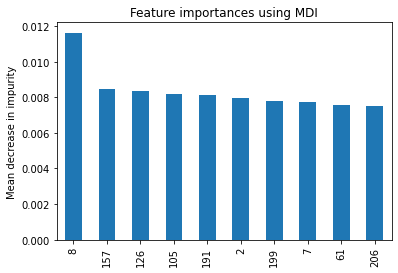

In [77]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [78]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[]

In [153]:
# y_train = y_train.to_numpy()
# y_valid = y_valid.to_numpy()

In [154]:
# from pytorch_tabnet.metrics import Metric
# from sklearn.metrics import roc_auc_score

# class auc_ovo(Metric):
#     def __init__(self):
#         self._name = "gini"
#         self._maximize = True

#     def __call__(self, y_true, y_score):
# #         auc = roc_auc_score(y_true, y_score[:, 1])
#         print(y_true.shape)
#         auc = roc_auc_score(y_true, y_score[:,1], multi_class='ovo')
# #         return max(2*auc - 1, 0.)
#         return auc

In [155]:
# clf = TabNetMultiTaskClassifier()
# clf.fit(
#     X_train, y_train,
#     eval_set=[(X_train, y_train), (X_valid, y_valid)],
#     eval_name=['train', 'valid'],
#     eval_metric=['balanced_accuracy'],
# #     eval_metric=[auc_ovo]
# )